# Apache Spark Introduction and Data Aggregation

### Setting up Spark
Install PySpark and required Apache Spark in Python. Also prepare Spark runtime.

In [1]:
# Install Spark
#!pip install pyspark==3.5.0 -q

# Install Java
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Set Java environment variable
import os
os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-17"

print("PySpark and Java installed successfully")

PySpark and Java installed successfully


Python environment configuration (Python interpretor for drivers + workers)

In [2]:
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

print("Driver Python:", sys.executable)
print("Worker Python:", os.environ["PYSPARK_PYTHON"])

Driver Python: d:\Lancaster University Coursework\Term 2\SSC 454 - Large scale platforms for AI and Data Analysis\Labs\venv\Scripts\python.exe
Worker Python: d:\Lancaster University Coursework\Term 2\SSC 454 - Large scale platforms for AI and Data Analysis\Labs\venv\Scripts\python.exe


### First SparkSession

Initialises Spark engine. Create SparkSession. Extracts SparkContext (connection between application and Spark cluster) as sc.

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

# Create a SparkSession
spark = SparkSession.builder \
    .appName("SSC454-SparkIntro") \
    .config("spark.driver.memory", "4g") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Get underlying SparkContext
sc = spark.sparkContext

print(f"Spark Version: {spark.version}")
print(f"Application Name: {spark.sparkContext.appName}")
print(f"Master: {spark.sparkContext.master}")

Spark Version: 3.5.0
Application Name: SSC454-SparkIntro
Master: local[*]


## RDDs - Resilient Distributed Datasets
It is the fundamental low-level data abstraction in Spark used to represent distributed collections of data that can be processed in parallel.

### Creating RDDs

`parallelize()` - Takes a local Python list adn distributes it into partitions. Each parition is processed in parallel as a "task" \
`getNumPartitions()` - Get total number of partitions \
`collect()` - Brings everything to driver 

In [5]:
# Method 1: Parallelize a Python collection
numbers = list(range(10))
numbers_rdd = sc.parallelize(numbers)

print(f"Type: {type(numbers_rdd)}")
print(f"Number of partitions: {numbers_rdd.getNumPartitions()}")
print(f"First 5 elements: {numbers_rdd.take(5)}")

# Method 1b: Parallelize with specified number of partitions
numbers_rdd_4part = sc.parallelize(numbers, 4)
print(f"Number of partitions: {numbers_rdd_4part.getNumPartitions()}")

# View the partitions
print("\nData in each partition:")
print(numbers_rdd_4part.glom().collect())

#Method 2: Create RDD from a text file
sample_text = """Apache Spark is a unified analytics engine for large-scale data processing.It provides high-level APIs in Java, Scala, Python and R.Spark powers a stack of libraries including SQL and DataFrames.It also includes MLlib for machine learning and GraphX for graph processing. Spark can run on Hadoop, Apache Mesos, Kubernetes, standalone, or in the cloud."""

with open("spark_intro.txt", "w") as f:
    f.write(sample_text)

# Load the text file as an RDD
text_rdd = sc.textFile("spark_intro.txt")
print(f"Number of lines: {text_rdd.count()}")
print("\nFirst 3 lines:")

for line in text_rdd.take(3):
    print(f" - {line}")

Type: <class 'pyspark.rdd.RDD'>
Number of partitions: 16
First 5 elements: [0, 1, 2, 3, 4]
Number of partitions: 4

Data in each partition:
[[0, 1], [2, 3], [4, 5], [6, 7, 8, 9]]
Number of lines: 1

First 3 lines:
 - Apache Spark is a unified analytics engine for large-scale data processing.It provides high-level APIs in Java, Scala, Python and R.Spark powers a stack of libraries including SQL and DataFrames.It also includes MLlib for machine learning and GraphX for graph processing. Spark can run on Hadoop, Apache Mesos, Kubernetes, standalone, or in the cloud.


### Transformations and Actions

*Transformations (lazy)* - Build a plan but do not compute immediately. Operation that creates a new RDD/DataFram from existing one without immediate computation \
*Actions (trigger execution)* - Force Spark to execute thr DAG. Trigger the actual execution of transformations and returns a result to driver program or writes data externally. 

In [6]:
# Transformation Examples
numbers = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# map: Apply a function to each element
squared = numbers.map(lambda x: x**2)
print(f"Original: {numbers.collect()}")
print(f"Squared: {squared.collect()}")

# filter: Keep only elements that match a condition
evens = numbers.filter(lambda x: x%2 == 0)
print(f"Evens: {evens.collect()}")

# Chaining transformations
even_squares = numbers.filter(lambda x: x%2 == 0).map(lambda x: x**2)
print(f"Even squares: {even_squares.collect()}")

# flatMap: Map then flatten
sentances = sc.parallelize(["Hello World", "Apache Spark", "Big Data"])

# map vs flatMap
words_map = sentances.map(lambda s: s.split())
words_flatmap = sentances.flatMap(lambda s: s.split())

print(f"Uisng map: {words_map.collect()}")
print(f"Using flatMap: {words_flatmap.collect()}")


# Action Examples
numbers = sc.parallelize([1, 2, 3, 4, 5])

print(f"collect(): {numbers.collect()}")
print(f"count(): {numbers.count()}")
print(f"first(): {numbers.first()}")
print(f"take(3): {numbers.take(3)}")
print(f"sum: {numbers.sum()}")
print(f"mean(): {numbers.mean()}")
print(f"max(): {numbers.max()}")
print(f"min(): {numbers.min()}")

# reduce: Aggregate elements
total = numbers.reduce(lambda a, b: a+b)
print(f"reduce(+): {total}")

Original: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Squared: [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
Evens: [2, 4, 6, 8, 10]
Even squares: [4, 16, 36, 64, 100]
Uisng map: [['Hello', 'World'], ['Apache', 'Spark'], ['Big', 'Data']]
Using flatMap: ['Hello', 'World', 'Apache', 'Spark', 'Big', 'Data']
collect(): [1, 2, 3, 4, 5]
count(): 5
first(): 1
take(3): [1, 2, 3]
sum: 15
mean(): 3.0
max(): 5
min(): 1
reduce(+): 15


### Lazy Evaluation

`count()` - Computes number of elements across all partiions, then reduces to a single integer

In [6]:
import time

# Create RDD and apply transformations
print("Creating RDD and transformations...")
start = time.time()
large_rdd = sc.parallelize(range(1000000))
transformed = large_rdd.map(lambda x: x*2).filter(lambda x: x % 4 == 0)

print(f"Time to define transformations: {time.time() - start:.4f} seconds")
print(f"Transformations are defined but not executed yet!")
print(f"Type of 'transformed': {type(transformed)}")

# Triggering execution with an action
print("\nCalling count() action...")
start = time.time()
result = transformed.count()
print(f"Time to execute: {time.time() - start:.4f} seconds")
print(f"Count: {result}")

Creating RDD and transformations...
Time to define transformations: 0.0030 seconds
Transformations are defined but not executed yet!
Type of 'transformed': <class 'pyspark.rdd.PipelinedRDD'>

Calling count() action...
Time to execute: 9.1571 seconds
Count: 500000


### Word Count Example

`flatMap()` - It is esssential as without it each line becomes a list of words inside RDD and nested structures occur that reduceByKey cannot use directly. Narrow transformation \
`reduceByKey()` - It is efficient as it does map-side partial aggregation inside partitions (combined effect) and then shuffles aggregated chunks, not raw data (faster). Combines data with same key

In [7]:
# Sample text
text = """Spark is fast and general purpose cluster computing systemSpark provides high level APIs in Java Scala Python and RSpark supports general computation graphs for data analysis. Spark has rich set of higher level tools including Spark SQLSpark SQL provides support for structured data processing"""

# Save to file
with open("wordcount_input.txt", "w") as f:
    f.write(text)

# Using RDDs
lines = sc.textFile("wordcount_input.txt")

# Step 1: Split each line into words
words = lines.flatMap(lambda line: line.lower().split())
print("Step 1 - Words:")
print(words.take(10))

# Step 2: Map each word to a (word, 1) pair
word_pairs = words.map(lambda word: (word, 1))
print("\nStep 2 - Word Pairs: ")
print(word_pairs.take(10))

# Step 3: Reduce by key - sum up counts for each word
word_counts = word_pairs.reduceByKey(lambda a, b: a+b)
print("\nStep 3 - Word Counts:")
print(word_counts.take(10))

# Step 4: Sort by count (descending)
sorted_counts = word_counts.sortBy(lambda x: -x[1])
print("\nTop 10 words:")
for word, count in sorted_counts.take(10):
    print(f" {word}: {count}")

# Word Count - Concise Version (One-Liner)
word_counts_concise = sc.textFile("wordcount_input.txt") \
    .flatMap(lambda line: line.lower().split()) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a+b) \
    .sortBy(lambda x: -x[1])

print("\n\nWord counts (concise version):")
for word, count in word_counts_concise.take(10):
    print(f" {word}: {count}")

Step 1 - Words:
['spark', 'is', 'fast', 'and', 'general', 'purpose', 'cluster', 'computing', 'systemspark', 'provides']

Step 2 - Word Pairs: 
[('spark', 1), ('is', 1), ('fast', 1), ('and', 1), ('general', 1), ('purpose', 1), ('cluster', 1), ('computing', 1), ('systemspark', 1), ('provides', 1)]

Step 3 - Word Counts:
[('fast', 1), ('and', 2), ('general', 2), ('computing', 1), ('systemspark', 1), ('high', 1), ('level', 2), ('java', 1), ('python', 1), ('supports', 1)]

Top 10 words:
 spark: 3
 and: 2
 general: 2
 level: 2
 for: 2
 provides: 2
 data: 2
 fast: 1
 computing: 1
 systemspark: 1


Word counts (concise version):
 spark: 3
 and: 2
 general: 2
 level: 2
 for: 2
 provides: 2
 data: 2
 fast: 1
 computing: 1
 systemspark: 1


## Spark DataFrames

### Creating DataFrames

Explicit schema is better as 
- Prevents wrong inference (numbers as string)
- Consistent types across runs
- Important in real pipelines

`show()` - Triggers computation and prints a sample

In [8]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql import Row

# Method 1: From a list of tuples
data = [
    ("Alice", 28, "Data Scientist", 75000),
    ("Bob", 35, "Software Engineer", 85000),
    ("Charlie", 32, "Data Analyst", 65000),
    ("Diana", 29, "ML Engineer", 90000),
    ("Eve", 41, "Data Scientist", 95000)
]
columns = ["name", "age", "role", "salary"]

df = spark.createDataFrame(data, columns)
df.show()

# Method 2: With explicit schema
schema = StructType([
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("role", StringType(), True),
    StructField("salary", IntegerType(), True)
])

df_with_schema = spark.createDataFrame(data, schema)
df_with_schema.printSchema()

# Method 3: From a pandas DataFrame
import pandas as pd

pandas_df = pd.DataFrame({
    "city": ["London", "Manchester", "Birmingham", "Leeds", "Glasgow"], 
    "population": [8982000, 547627, 1141816, 793139, 626410], 
    "country": ["England", "England", "England", "England", "Scotland"]
})

spark_df = spark.createDataFrame(pandas_df)
spark_df.show()

# Method 4: From Row Objects
row_data = [
    Row(product="Laptop", price=999.99, quantity=50),
    Row(product="Mouse", price=29.99, quantity=200),
    Row(product="Keyboard", price=79.99, quantity=150)
]

df_rows = spark.createDataFrame(row_data)
df_rows.show()

+-------+---+-----------------+------+
|   name|age|             role|salary|
+-------+---+-----------------+------+
|  Alice| 28|   Data Scientist| 75000|
|    Bob| 35|Software Engineer| 85000|
|Charlie| 32|     Data Analyst| 65000|
|  Diana| 29|      ML Engineer| 90000|
|    Eve| 41|   Data Scientist| 95000|
+-------+---+-----------------+------+

root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- role: string (nullable = true)
 |-- salary: integer (nullable = true)

+----------+----------+--------+
|      city|population| country|
+----------+----------+--------+
|    London|   8982000| England|
|Manchester|    547627| England|
|Birmingham|   1141816| England|
|     Leeds|    793139| England|
|   Glasgow|    626410|Scotland|
+----------+----------+--------+

+--------+------+--------+
| product| price|quantity|
+--------+------+--------+
|  Laptop|999.99|      50|
|   Mouse| 29.99|     200|
|Keyboard| 79.99|     150|
+--------+------+--------+



### Loading Data from External Sources

NASA temperature dataset \
`explode()` - converts each element in array to its own row \
`lit()` - create a constant literal value

In [9]:
# Gloval Land Temperature dataset from NASA GISS (official GISTEMP v4 dataset)
# import requests

# url = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"
# response = requests.get(url)

# with open("global_temp.csv", "wb") as f:
#     f.write(response.content)

# Preview
!head -15 global_temp.csv

# Using pandas to clean, then covert to Spark (Simple Approach)
import pandas as pd
from pyspark.sql.functions import col, lit, explode, array, struct

# Read
pdf = pd.read_csv("global_temp.csv", skiprows=1)
print("Pandas columns:", pdf.columns.tolist())
print(pdf.head())

# Convert to Spark DataFrame
temp_df_raw = spark.createDataFrame(pdf)

print("\nSpark DataFrame:")
temp_df_raw.show(5)
print("\nSchema:")
temp_df_raw.printSchema()

# Transform to long format
month_cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
temp_df = temp_df_raw.select(
    col("Year"),
    explode(array([struct(lit(i+1).alias("Month"), col(m).cast("double").alias("Mean")) for i, m in enumerate(month_cols)])).alias("data")
).select(
    col("Year").cast("int").alias("Year"),
    col("data.Month").alias("Month"),
    col("data.Mean").alias("Mean")
).filter(col("Mean").isNotNull())

# Add a Source columns for consistency
temp_df = temp_df.withColumn("Source", lit("GIMSTEMP"))

print("\nTransformed data (long format):")
temp_df.show(10)

print("\nSchema:")
temp_df.printSchema()

print(f"\nTotal records: {temp_df.count()}")

'head' is not recognized as an internal or external command,
operable program or batch file.


Pandas columns: ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'J-D', 'D-N', 'DJF', 'MAM', 'JJA', 'SON']
   Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0  1880 -0.19 -0.25 -0.10 -0.17 -0.11 -0.22 -0.19 -0.11 -0.15 -0.24 -0.23   
1  1881 -0.20 -0.15  0.03  0.04  0.05 -0.19  0.00 -0.04 -0.16 -0.22 -0.19   
2  1882  0.15  0.13  0.04 -0.17 -0.15 -0.23 -0.17 -0.08 -0.15 -0.24 -0.17   
3  1883 -0.30 -0.37 -0.13 -0.18 -0.17 -0.08 -0.07 -0.14 -0.21 -0.11 -0.23   
4  1884 -0.13 -0.08 -0.36 -0.41 -0.34 -0.36 -0.30 -0.27 -0.27 -0.25 -0.34   

    Dec   J-D   D-N   DJF   MAM   JJA   SON  
0 -0.18 -0.18   ***   *** -0.13 -0.17 -0.21  
1 -0.07 -0.09  -.10  -.18  0.04 -0.08 -0.19  
2 -0.36 -0.12  -.09   .07 -0.09 -0.16 -0.19  
3 -0.11 -0.18  -.20  -.34 -0.16 -0.10 -0.19  
4 -0.31 -0.29  -.27  -.11 -0.37 -0.31 -0.29  

Spark DataFrame:
+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+---

### DataFrame Operations

`select()` - Pick columns \
`withColumns()` - Add computed columns \
`filter()` - Row filtering \
`orderBy()` - Sorting triggers a shuffle if global sort is required

In [10]:
from pyspark.sql.functions import col, year, month, avg, max, min, count, round

# Select columns
print("Select specific columns:")
temp_df.select("Year", "Month", "Mean").show(5)

# Select with expression - convert to Fahrenheit
print("\nSelect with expressions (add Fahrenheit):")
temp_df.select(
    col("Year"),
    col("Month"),
    col("Mean"),
    round(col("Mean") * 1.8 + 32, 2).alias("Mean_Fahrenheit")
).show(5)

# Filter rows
print("Filter: Temperatures aobve 0.5C anomaly:")
temp_df.filter(col("Mean")>0.5).show(5)

# Multiple Conditions
print("\nFilter: Year 2020 or later with mean > 0.8:")
temp_df.filter(
    (col("Year") >= 2020) & (col("Mean") > 0.8)
).show(10)

# Add new columns with withColumn
from pyspark.sql.functions import when

# Derived columns
temp_df_enhanced = temp_df \
    .withColumn("Mean_F", round(col("Mean") * 1.8 + 32, 2)) \
    .withColumn("Decade", (col("Year") / 10).cast("int") * 10) \
    .withColumn("Season", 
        when(col("Month").isin(12, 1, 2), "Winter")
        .when(col("Month").isin(3, 4, 5), "Spring")
        .when(col("Month").isin(6,7,8), "Summer")
        .otherwise("Autumn")
    )

temp_df_enhanced.show(10)

# Sorting
print("Sorted by Mean (descending - Warmest temperature anomalies:)")
temp_df_enhanced.orderBy(col("Mean").desc()).show(10)

print("\nSorted by Mean (ascending) - Coldest temperature anomalies:")
temp_df_enhanced.orderBy(col("Mean").asc()).show(10)

Select specific columns:
+----+-----+-----+
|Year|Month| Mean|
+----+-----+-----+
|1880|    1|-0.19|
|1880|    2|-0.25|
|1880|    3| -0.1|
|1880|    4|-0.17|
|1880|    5|-0.11|
+----+-----+-----+
only showing top 5 rows


Select with expressions (add Fahrenheit):
+----+-----+-----+---------------+
|Year|Month| Mean|Mean_Fahrenheit|
+----+-----+-----+---------------+
|1880|    1|-0.19|          31.66|
|1880|    2|-0.25|          31.55|
|1880|    3| -0.1|          31.82|
|1880|    4|-0.17|          31.69|
|1880|    5|-0.11|           31.8|
+----+-----+-----+---------------+
only showing top 5 rows

Filter: Temperatures aobve 0.5C anomaly:
+----+-----+----+--------+
|Year|Month|Mean|  Source|
+----+-----+----+--------+
|1981|    1|0.53|GIMSTEMP|
|1983|    1|0.53|GIMSTEMP|
|1988|    1|0.57|GIMSTEMP|
|1988|    3|0.52|GIMSTEMP|
|1990|    3| 0.8|GIMSTEMP|
+----+-----+----+--------+
only showing top 5 rows


Filter: Year 2020 or later with mean > 0.8:
+----+-----+----+--------+
|Year|Month|Mea

### Data Aggregation and Grouping

`agg(count, avg, max, min)` - Column-level aggregations. Scans partitions, compute partial aggregates, merge them (reduce). \
`groupBy("Year")` - Creates groups per year .

Overall statistics:
+-------------+--------+--------+--------+
|total_records|avg_temp|max_temp|min_temp|
+-------------+--------+--------+--------+
|         1752|  0.0814|    1.48|   -0.82|
+-------------+--------+--------+--------+

Yearly temperature statistics (GISTEMP):
+----+--------+--------+--------+
|Year|Avg_Temp|Max_Temp|Min_Temp|
+----+--------+--------+--------+
|1880| -0.1783|    -0.1|   -0.25|
|1881| -0.0917|    0.05|   -0.22|
|1882| -0.1167|    0.15|   -0.36|
|1883|  -0.175|   -0.07|   -0.37|
|1884|  -0.285|   -0.08|   -0.41|
|1885| -0.3383|   -0.11|   -0.59|
|1886| -0.3183|   -0.19|   -0.51|
|1887| -0.3692|   -0.25|   -0.73|
|1888| -0.1767|    0.02|   -0.41|
|1889| -0.1092|    0.16|   -0.34|
|1890| -0.3575|   -0.25|   -0.45|
|1891| -0.2283|   -0.04|   -0.47|
|1892| -0.2742|   -0.12|   -0.42|
|1893| -0.3142|   -0.14|   -0.81|
|1894|   -0.31|   -0.22|   -0.53|
|1895| -0.2308|   -0.11|   -0.43|
|1896| -0.1192|    0.06|   -0.31|
|1897| -0.1158|   -0.02|   -0.21|
|1898| -0

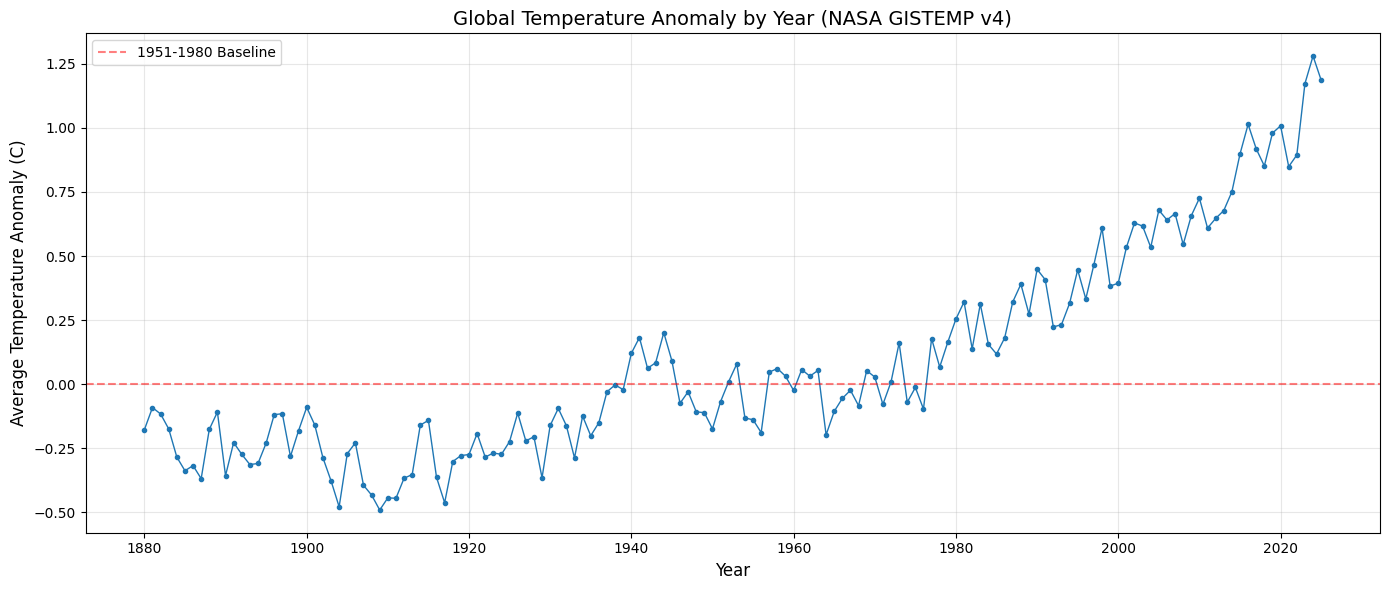

In [11]:
# Basic Aggregation
print("Overall statistics:")
temp_df_enhanced.agg(
    count("*").alias("total_records"),
    round(avg("Mean"), 4).alias("avg_temp"),
    round(max("Mean"), 4).alias("max_temp"),
    round(min("Mean"), 4).alias("min_temp")
).show()

# Group by Year and calculate average temperature
yearly_avg = temp_df_enhanced \
    .groupBy("Year") \
    .agg(
        round(avg("Mean"), 4).alias("Avg_Temp"),
        round(max("Mean"), 4).alias("Max_Temp"),
        round(min("Mean"), 4).alias("Min_Temp")
    ) \
    .orderBy("Year")

print("Yearly temperature statistics (GISTEMP):")
yearly_avg.show(20)

# Compare by decade
decade_comparision = temp_df_enhanced \
    .groupBy("Decade") \
    .agg(
        count("*").alias("Record_Count"),
        round(avg("Mean"), 4).alias("Avg_Temp"),
        round(max("Mean"), 4).alias("Max_Temp"),
        round(min("Mean"), 4).alias("Min_Temp")
    ) \
    .orderBy("Decade")

print("Temperature anomalies by Decade:")
decade_comparision.show()

# Visualise the trends using matplotlib
import matplotlib.pyplot as plt

# Covnert to pandas for plotting
yearly_pandas = yearly_avg.toPandas()

plt.figure(figsize=(14, 6))
plt.plot(yearly_pandas["Year"], yearly_pandas["Avg_Temp"], marker='o', markersize=3, linewidth=1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Temperature Anomaly (C)", fontsize=12)
plt.title("Global Temperature Anomaly by Year (NASA GISTEMP v4)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='1951-1980 Baseline')
plt.legend()
plt.tight_layout()
plt.show()

### Working with Missing Data

`na.drop()` - Drops rows containing null \
`na.fill()` - Replaces null values with defaults

In [12]:
from pyspark.sql.functions import when, isnan, isnull

# Create DataFrame with Missing Values
data_with_nulls = [
    ("A", 25, 50000.0),
    ("B", None, 60000.0), 
    ("C", 35, None), 
    ("D", None, None), 
    ("E", 45, 80000.0)
]

df_nulls = spark.createDataFrame(data_with_nulls, ["name", "age", "salary"])
print("DataFrame with null values:")
df_nulls.show()

# Count nulls per column
print("Null counts per column:")
df_nulls.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_nulls.columns
]).show()

# Drop rows with any null values
print("Drop rows with any null:")
df_nulls.na.drop().show()

# Drop rows when specific columns are null
print("Drop rows when age is null:")
df_nulls.na.drop(subset=["age"]).show()

# Fill null values
print("Fill nulls with 0:")
df_nulls.na.fill(0).show()

# Fill with different values per column
print("Fill with specific values per column:")
df_nulls.na.fill({"age": 30, "salary": 50000.0}).show()

DataFrame with null values:
+----+----+-------+
|name| age| salary|
+----+----+-------+
|   A|  25|50000.0|
|   B|NULL|60000.0|
|   C|  35|   NULL|
|   D|NULL|   NULL|
|   E|  45|80000.0|
+----+----+-------+

Null counts per column:
+----+---+------+
|name|age|salary|
+----+---+------+
|   0|  2|     2|
+----+---+------+

Drop rows with any null:
+----+---+-------+
|name|age| salary|
+----+---+-------+
|   A| 25|50000.0|
|   E| 45|80000.0|
+----+---+-------+

Drop rows when age is null:
+----+---+-------+
|name|age| salary|
+----+---+-------+
|   A| 25|50000.0|
|   C| 35|   NULL|
|   E| 45|80000.0|
+----+---+-------+

Fill nulls with 0:
+----+---+-------+
|name|age| salary|
+----+---+-------+
|   A| 25|50000.0|
|   B|  0|60000.0|
|   C| 35|    0.0|
|   D|  0|    0.0|
|   E| 45|80000.0|
+----+---+-------+

Fill with specific values per column:
+----+---+-------+
|name|age| salary|
+----+---+-------+
|   A| 25|50000.0|
|   B| 30|60000.0|
|   C| 35|50000.0|
|   D| 30|50000.0|
|   E| 45|80

## Spark SQL

### Creating Temporary Views

Session-scoped

In [13]:
# Register temperature DataFrame as temporary view
temp_df_enhanced.createOrReplaceTempView("temperatures")

print("Temporary view 'temperature' created successfully!")
print("\nAvailable columns:")
print(temp_df_enhanced.columns)

Temporary view 'temperature' created successfully!

Available columns:
['Year', 'Month', 'Mean', 'Source', 'Mean_F', 'Decade', 'Season']


### Writing SQL Queries

Uses Catalyst optimizer to optimize query plans

In [14]:
# Basic SELECT Query
result = spark.sql("""
    SELECT Year, Month, Mean, Mean_F, Season
    FROM temperatures
    LIMIT 10
""")
result.show()

# Filtering with WHERE
high_temps = spark.sql("""
    SELECT Year, Month, Mean, Season, Decade
    FROM temperatures
    WHERE Mean > 1.0
    ORDER BY Mean DESC
    LIMIT 15
""")

print("Months with temperature anomaly > 1.0 C:")
high_temps.show()

# Aggregation with GROUP BY
yearly_stats = spark.sql("""
    SELECT
        Year, 
        ROUND(AVG(Mean), 4) as avg_temp,
        ROUND(MAX(Mean), 4) as max_temp,
        ROUND(MIN(Mean), 4) as min_temp,
        COUNT(*) as num_records
    FROM temperatures
    GROUP BY Year
    HAVING AVG(Mean) > 0.5
    ORDER BY avg_temp DESC
""")

print("Years with average temperature anomaly > 0.5 C:")
yearly_stats.show(20)

# Aggregation by decade
warmest_per_decade = spark.sql("""
    SELECT 
        Decade,
        ROUND(AVG(Mean), 4) as Avg_Temp,
        COUNT(*) as Num_Records, 
        MIN(Year) as First_Year,
        MAX(Year) as Last_Year
    FROM temperatures
    GROUP BY Decade
    ORDER BY Decade
""")

print("Average temperature anomaly by decade:")
warmest_per_decade.show()

+----+-----+-----+------+------+
|Year|Month| Mean|Mean_F|Season|
+----+-----+-----+------+------+
|1880|    1|-0.19| 31.66|Winter|
|1880|    2|-0.25| 31.55|Winter|
|1880|    3| -0.1| 31.82|Spring|
|1880|    4|-0.17| 31.69|Spring|
|1880|    5|-0.11|  31.8|Spring|
|1880|    6|-0.22|  31.6|Summer|
|1880|    7|-0.19| 31.66|Summer|
|1880|    8|-0.11|  31.8|Summer|
|1880|    9|-0.15| 31.73|Autumn|
|1880|   10|-0.24| 31.57|Autumn|
+----+-----+-----+------+------+

Months with temperature anomaly > 1.0 C:
+----+-----+----+------+------+
|Year|Month|Mean|Season|Decade|
+----+-----+----+------+------+
|2023|    9|1.48|Autumn|  2020|
|2024|    2|1.44|Winter|  2020|
|2023|   11| 1.4|Autumn|  2020|
|2024|    3|1.39|Spring|  2020|
|2025|    1|1.38|Winter|  2020|
|2016|    2|1.37|Winter|  2010|
|2023|   12|1.37|Winter|  2020|
|2025|    3|1.36|Spring|  2020|
|2016|    3|1.35|Spring|  2010|
|2023|   10|1.34|Autumn|  2020|
|2024|   10|1.33|Autumn|  2020|
|2024|    4|1.31|Spring|  2020|
|2024|   11| 1.3

### Combining DataFrame API and SQL

In [15]:
# Start with SQL, continue with DataFrame API
recent_years = spark.sql("""
    SELECT *
    FROM temperatures
    WHERE Year>=2000
""")

# DataFrame Operations
monthly_pattern= recent_years \
    .groupBy("Month") \
    .agg(
        round(avg("Mean"), 4).alias("Avg_Temp"),
        count("*").alias("Count")
    ) \
    .orderBy("Month")

print("Montly temperature pattern (2000+):")
monthly_pattern.show(12)

# Result registered as new view
monthly_pattern.createOrReplaceTempView("monthly_patterns")

# Query new view
warmest_months = spark.sql("""
    SELECT 
        Month, 
        Avg_Temp,
        CASE
            WHEN Month IN (12, 1, 2) THEN 'Winter'
            WHEN Month IN (3, 4, 5) THEN 'Spring'
            WHEN Month in (6, 7, 8) THEN 'Summer'
            ELSE 'Autumn'
        END as Season
    FROM monthly_patterns
    ORDER BY Avg_Temp DESC
""")

warmest_months.show()

Montly temperature pattern (2000+):
+-----+--------+-----+
|Month|Avg_Temp|Count|
+-----+--------+-----+
|    1|  0.7892|   26|
|    2|  0.7954|   26|
|    3|  0.8773|   26|
|    4|  0.7823|   26|
|    5|  0.7377|   26|
|    6|  0.7219|   26|
|    7|    0.73|   26|
|    8|  0.7662|   26|
|    9|  0.7892|   26|
|   10|  0.8162|   26|
|   11|   0.825|   26|
|   12|  0.7669|   26|
+-----+--------+-----+

+-----+--------+------+
|Month|Avg_Temp|Season|
+-----+--------+------+
|    3|  0.8773|Spring|
|   11|   0.825|Autumn|
|   10|  0.8162|Autumn|
|    2|  0.7954|Winter|
|    1|  0.7892|Winter|
|    9|  0.7892|Autumn|
|    4|  0.7823|Spring|
|   12|  0.7669|Winter|
|    8|  0.7662|Summer|
|    5|  0.7377|Spring|
|    7|    0.73|Summer|
|    6|  0.7219|Summer|
+-----+--------+------+



# Exercises

## Exercise 1
MovieLens 100K Dataset

In [ ]:
# Load LovieLens 100K Dataset
import urllib.request, zipfile, os

url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
zip_path = "ml-100k.zip"

# Download file
urllib.request.urlretrieve(url, zip_path)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Load the rating data
ratings_schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("movie_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True)
])

ratings_df = spark.read \
    .option("delimiter", "\t") \
    .schema(ratings_schema) \
    .csv("ml-100k/u.data")

# Load movie titles
movies_df = spark.read \
    .option("delimiter", "|") \
    .csv("ml-100k/u.item") \
    .select(
        col("_c0").cast("int").alias("movie_id"),
        col("_c1").alias("title"),
        col("_c2").alias("release_date")
    )

print("Ratings DataFrame:")
ratings_df.show(5)

print("\nMovies DataFrame:")
movies_df.show(5)

# Register as views for SQL
ratings_df.createOrReplaceTempView("ratings")
movies_df.createOrReplaceTempView("movies")

Ratings DataFrame:
+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
|     22|     377|     1|878887116|
|    244|      51|     2|880606923|
|    166|     346|     1|886397596|
+-------+--------+------+---------+
only showing top 5 rows


Movies DataFrame:
+--------+-----------------+------------+
|movie_id|            title|release_date|
+--------+-----------------+------------+
|       1| Toy Story (1995)| 01-Jan-1995|
|       2| GoldenEye (1995)| 01-Jan-1995|
|       3|Four Rooms (1995)| 01-Jan-1995|
|       4|Get Shorty (1995)| 01-Jan-1995|
|       5|   Copycat (1995)| 01-Jan-1995|
+--------+-----------------+------------+
only showing top 5 rows



### Task 1.1
Calculate and display:
- Total number of ratings
- Number of unique users
- Number of unique movies
- Average rating across all movies

In [17]:
from pyspark.sql.functions import avg
import builtins

# Total number of ratings
total_ratings = ratings_df.count()

# Number of Unique Users
unique_users = ratings_df.select("user_id").distinct().count()

# Number of Unique Movies
unique_movies = ratings_df.select("movie_id").distinct().count()

# Average Rating 
average_rating = ratings_df.select(avg("rating")).collect()[0][0]

print("Total number of ratings:", total_ratings)
print("Number of unique users:", unique_users)
print("Number of unique movies:", unique_movies)
print("Average rating across all movies:", builtins.round(average_rating, 3))


Total number of ratings: 100000
Number of unique users: 943
Number of unique movies: 1682
Average rating across all movies: 3.53


### Task 1.2
Show the distribution of ratings (how many ratings of each value 1-5). Order by rating value.

In [18]:
from pyspark.sql.functions import count 

rating_distribution = ratings_df.groupby("rating") \
    .agg(count("*").alias("count")) \
    .orderBy("rating")

rating_distribution.show()

+------+-----+
|rating|count|
+------+-----+
|     1| 6110|
|     2|11370|
|     3|27145|
|     4|34174|
|     5|21201|
+------+-----+



### Task 1.3
Find the top 10 highest-rated movies that have at least 100 ratings. Join with the movies table to show the movie title.

In [19]:
from pyspark.sql.functions import count, avg

# Group by movie_id and compute avg rating + rating count
movie_stats = ratings_df.groupBy("movie_id") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("rating").alias("rating_count")
    )

# Filter with atleast 100 ratings
filtered_movies = movie_stats.filter("rating_count >= 100")

# Join with movies_df to get titles
joined_df = filtered_movies.join(movies_df, on="movie_id", how="inner")

# Order by average rating descending for top 10
top_movies = joined_df.orderBy("avg_rating", ascending=False).select(
    "title", "avg_rating", "rating_count"
).limit(10)

top_movies.show(truncate=False)

+--------------------------------+------------------+------------+
|title                           |avg_rating        |rating_count|
+--------------------------------+------------------+------------+
|Close Shave, A (1995)           |4.491071428571429 |112         |
|Schindler's List (1993)         |4.466442953020135 |298         |
|Wrong Trousers, The (1993)      |4.466101694915254 |118         |
|Casablanca (1942)               |4.45679012345679  |243         |
|Shawshank Redemption, The (1994)|4.445229681978798 |283         |
|Rear Window (1954)              |4.3875598086124405|209         |
|Usual Suspects, The (1995)      |4.385767790262173 |267         |
|Star Wars (1977)                |4.3584905660377355|583         |
|12 Angry Men (1957)             |4.344             |125         |
|Citizen Kane (1941)             |4.292929292929293 |198         |
+--------------------------------+------------------+------------+



### Task 1.4
Write a SQL query to find the top 5 users who have rated the most movies. Show their user_id, number of ratings, and average rating they give.

In [20]:
spark.sql("""
    SELECT
        user_id,
        COUNT(*) AS number_of_ratings,
        ROUND(AVG(rating), 3) AS average_rating_given
    FROM ratings
    GROUP BY user_id
    ORDER BY number_of_ratings DESC
    LIMIT 5
""").show(5)

+-------+-----------------+--------------------+
|user_id|number_of_ratings|average_rating_given|
+-------+-----------------+--------------------+
|    405|              737|               1.834|
|    655|              685|               2.908|
|     13|              636|               3.097|
|    450|              540|               3.865|
|    276|              518|               3.465|
+-------+-----------------+--------------------+



## Exercise 2
E-Commerce Sales Analysis

In [21]:
# Synthetic E-Commerce Dataset
import random
from datetime import datetime, timedelta
from builtins import round as python_round

# Seed for Reproducibility
random.seed(42)

# Data Generation
categories = ["Electronics", "Clothing", "Home & Garden", "Books", "Sports"]
products = { "Electronics": ["Laptop", "Phone", "Tablet", "Headphones", "Camera"], "Clothing": ["T-Shirt", "Jeans", "Jacket", "Shoes", "Hat"], "Home & Garden": ["Chair", "Table", "Lamp", "Plant", "Vase"], "Books": ["Fiction", "Non-Fiction", "Technical", "Children", "Comics"], "Sports": ["Football", "Tennis Racket", "Yoga Mat", "Dumbbells", "Bicycle"]}
regions = ["North", "South", "East", "West", "Central"]

sales_data = []
base_date = datetime(2024, 1, 1)

for i in range(5000):
    category = random.choice(categories)
    product = random.choice(products[category])
    date = base_date + timedelta(days=random.randint(0, 364))
    quantity = random.randint(1, 10)
    base_price = random.uniform(10, 500)
    discount = random.choice([0.0, 0.0, 0.1, 0.15, 0.2, 0.25])
    price = python_round(base_price * (1 - discount), 2)
    total = python_round(price * quantity, 2)

    sales_data.append((
        i+1,
        date.strftime("%Y-%m-%d"),
        category,
        product,
        random.choice(regions),
        float(quantity),
        float(price),
        float(total),
        float(discount)
    ))

# Create DataFrame
sales_columns = ["order_id", "order_date", "category", "product", "region", "quantity", "unit_price", "total", "discount"]
sales_df = spark.createDataFrame(sales_data, sales_columns)

# Add month column
from pyspark.sql.functions import substring
sales_df = sales_df.withColumn("month", substring("order_date", 1, 7))

print("E-commerce Sales Data:")
sales_df.show(10)

print(f"\nTotal records: {sales_df.count()}")

# Register as View
sales_df.createOrReplaceTempView("sales")

E-commerce Sales Data:
+--------+----------+-----------+-----------+-------+--------+----------+-------+--------+-------+
|order_id|order_date|   category|    product| region|quantity|unit_price|  total|discount|  month|
+--------+----------+-----------+-----------+-------+--------+----------+-------+--------+-------+
|       1|2024-05-20|Electronics|     Laptop|  North|     4.0|     89.53| 358.12|    0.25|2024-05|
|       2|2024-10-29|     Sports|   Football|  South|     7.0|     25.57| 178.99|     0.0|2024-10|
|       3|2024-11-04|   Clothing|        Hat|Central|     1.0|    213.76| 213.76|    0.25|2024-11|
|       4|2024-08-17|      Books|Non-Fiction|  South|    10.0|    146.31| 1463.1|     0.0|2024-08|
|       5|2024-05-22|      Books|  Technical|  North|     3.0|    103.95| 311.85|     0.1|2024-05|
|       6|2024-02-19|Electronics| Headphones|   East|     6.0|    340.22|2041.32|     0.2|2024-02|
|       7|2024-10-01|Electronics| Headphones|  North|     2.0|     413.8|  827.6|    0

### Task 2.1
Calculate total sales, number of orders, and average order value for each category. Order by total sales (descending).

In [22]:
from pyspark.sql.functions import sum, count, avg, round

category_sales = sales_df.groupBy("category") \
    .agg(
        round(sum("total"), 2).alias("total_sales"),
        count("*").alias("number_of_orders"),
        round(avg("total"), 2).alias("average_order_value")
    ) \
    .orderBy("total_sales", ascending=False)

category_sales.show()

+-------------+-----------+----------------+-------------------+
|     category|total_sales|number_of_orders|average_order_value|
+-------------+-----------+----------------+-------------------+
|        Books|  1279836.4|            1055|            1213.12|
|  Electronics|  1219652.4|            1016|            1200.45|
|       Sports| 1215981.57|             984|            1235.75|
|     Clothing| 1214161.95|            1008|            1204.53|
|Home & Garden| 1165770.74|             937|            1244.15|
+-------------+-----------+----------------+-------------------+



### Task 2.2: Monthly Trend Analysis

Analyze monthly sales trends:
- Calculate total sales per month
- Show results ordered by month
- Create a simple visualization of the trend

In [23]:
# DataFrame API
monthly_sales = sales_df.groupBy("month") \
    .agg(round(sum("total"), 2).alias("total_sales")) \
    .orderBy("month")

monthly_sales.show()

# SQL Version
spark.sql("""
    SELECT
        month,
        ROUND(SUM(total), 2) AS total_sales
    FROM sales
    GROUP BY month
    ORDER BY month
""").show()

+-------+-----------+
|  month|total_sales|
+-------+-----------+
|2024-01|  536235.31|
|2024-02|  545914.16|
|2024-03|   585173.8|
|2024-04|  488161.87|
|2024-05|  466505.77|
|2024-06|  521747.02|
|2024-07|  517782.16|
|2024-08|  417721.66|
|2024-09|   462823.3|
|2024-10|  504219.59|
|2024-11|  541407.99|
|2024-12|  507710.43|
+-------+-----------+

+-------+-----------+
|  month|total_sales|
+-------+-----------+
|2024-01|  536235.31|
|2024-02|  545914.16|
|2024-03|   585173.8|
|2024-04|  488161.87|
|2024-05|  466505.77|
|2024-06|  521747.02|
|2024-07|  517782.16|
|2024-08|  417721.66|
|2024-09|   462823.3|
|2024-10|  504219.59|
|2024-11|  541407.99|
|2024-12|  507710.43|
+-------+-----------+



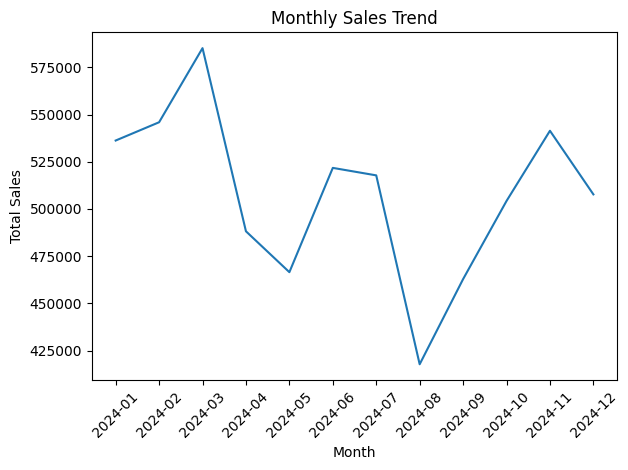

In [24]:
# Visualisation
import matplotlib.pyplot as plt

# Collect data
data = monthly_sales.collect()

months = [row["month"] for row in data]
sales = [row["total_sales"] for row in data]

plt.figure()
plt.plot(months, sales)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trend")
plt.tight_layout()
plt.show()

### Task 2.3: Regional Performance
Using SQL, find:
- Total sales by region
- The best-selling product in each region

In [25]:
spark.sql("""
    SELECT
        region,
        ROUND(SUM(total), 2) as total_sales
    FROM sales
    GROUP BY region
    ORDER BY total_sales DESC
""").show()

+-------+-----------+
| region|total_sales|
+-------+-----------+
|Central| 1267072.11|
|   East| 1238229.28|
|   West| 1215615.87|
|  South| 1205307.41|
|  North| 1169178.39|
+-------+-----------+



### Task 2.4: Discount Impact Analysis
Analyze the relationship between discounts and sales:
- Group orders by discount level (0%, 10%, 15%, 20%, 25%)
- Calculate average order value and total quantity for each discount level
- What patterns do you observe?

In [26]:
# DataFrame API
discount_analysis = sales_df.groupBy("discount") \
    .agg(
        round(avg("total"), 2).alias("average_order_value"),
        sum("quantity").alias("total_quantity")
    ) \
    .orderBy("discount")

discount_analysis.show()


# SQL Version
spark.sql("""
    SELECT
        discount,
        ROUND(AVG(total), 2) AS average_order_value,
        SUM(quantity) AS total_quantity
    FROM sales
    GROUP BY discount
    ORDER BY discount
""").show()

+--------+-------------------+--------------+
|discount|average_order_value|total_quantity|
+--------+-------------------+--------------+
|     0.0|            1391.26|        8736.0|
|     0.1|            1250.58|        4330.0|
|    0.15|            1166.08|        4487.0|
|     0.2|            1096.27|        4514.0|
|    0.25|            1048.08|        5017.0|
+--------+-------------------+--------------+

+--------+-------------------+--------------+
|discount|average_order_value|total_quantity|
+--------+-------------------+--------------+
|     0.0|            1391.26|        8736.0|
|     0.1|            1250.58|        4330.0|
|    0.15|            1166.08|        4487.0|
|     0.2|            1096.27|        4514.0|
|    0.25|            1048.08|        5017.0|
+--------+-------------------+--------------+



In [27]:
# Stop the Spark session
spark.stop()
print("Spark session stopped.")

Spark session stopped.
